# 0. Setup Environment & Load Integrated Data

In [226]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import kruskal
from IPython.display import display, Markdown

# Setup environment and display options
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10, 6)

# Define paths and columns (These columns were created in the previous notebook)
DATA_PATH = "data/integrated/"
BASELINE_INTEGRATED_FILE = "df_baseline_integrated.csv"
LONGITUDINAL_INTEGRATED_FILE = "df_longit_integrated.csv"

# Define CRITICAL Columns
CRITICAL_FEATURES = [
    'SubjectNumber', 'Visit', 'ABM_stage', 'Age_V2', 'Age_V3', 'CVT_LPP_C3', 'CVT_LPP_C4', 
    'CVT_LPP_Cz', 'CVT_LPP_F3', 'CVT_LPP_F4', 'CVT_LPP_F7', 'CVT_LPP_F8', 'CVT_LPP_Fp1',
    'CVT_LPP_Fp2', 'CVT_LPP_Fz', 'CVT_LPP_O1', 'CVT_LPP_O2', 'CVT_LPP_P3', 'CVT_LPP_P4',
    'CVT_LPP_POz', 'CVT_LPP_Pz', 'CVT_LPP_T3', 'CVT_LPP_T4', 'CVT_LPP_T5', 'CVT_LPP_T6',
    'CVT_LPPmaxLoc_C3', 'CVT_LPPmaxLoc_C4', 'CVT_LPPmaxLoc_Cz', 'CVT_LPPmaxLoc_F3', 
    'CVT_LPPmaxLoc_F4', 'CVT_LPPmaxLoc_F7', 'CVT_LPPmaxLoc_F8', 'CVT_LPPmaxLoc_Fp1'
]

# For Baseline
MCI_SCORE_B = 'MCI_score_base'      # float → The calculated MCI score at baseline (V1)
DIAGNOSIS_B = 'Diagnosis_base'      # float → Binary diagnostic label derived from Condition (HC→0, MCI→1); stored as float so NaN possible
CONDITION_CLEAN_B = 'Condition_clean'    # string → Cleaned condition label used for baseline classification
BASELINE_SPESIFIC_FEATURES = [MCI_SCORE_B, DIAGNOSIS_B, CONDITION_CLEAN_B]



# For Longitudinal
CONDITION_L = 'Condition'                   # string → Cleaned condition label used for longitudinal classification
MCI_SCORE_V1_L = 'MCI_score_v1'             # float → MCI score at first visit (V1)
MCI_SCORE_V2_L = 'MCI_score_v2'             # float → MCI score at second visit (V2)
DIAGNOSIS_V1_L = 'Diagnosis_v1'             # float → Binary diagnosis based on condition (V1)
DIAGNOSIS_V2_L = 'Diagnosis_v2'             # float → Binary diagnosis based on condition (V2)
MCI_SCORE_DIFF_L = 'MCI_score_diff'         # float → Numeric difference MCI_score_v2 - MCI_score_v1 (when both exist)
MCI_PROGRESSION_L = 'MCI_progression'       # float → Δ-based progression class (1.0 progression, 0.0 stable, -1.0 regression, NaN missing)
MCI_PROGRESSION_LABEL_L = 'MCI_progression_label'  # object → Human-readable label ('progression', 'stable', 'regression/improvement')
MCI_DIAG_THRSLD_BASED_V1_L = 'MCI_diag_thrsld_based_v1'  # float → Threshold-based diagnostic for V1 (cutoff ≈ 0.237787)
MCI_DIAG_THRSLD_BASED_V2_L = 'MCI_diag_thrsld_based_v2'  # float → Threshold-based diagnostic for V2 (same semantics as V1)
MCI_PROGRESSION_DIAG_THRSLD_BASED_L = 'MCI_progression_diag_thrsld_based'  # float → Subject-level diagnostic progression (V1→V2 change)
LONGITUDINAL_SPESIFIC_FEATURES = [
    MCI_SCORE_V1_L, MCI_SCORE_V2_L, DIAGNOSIS_V1_L, DIAGNOSIS_V2_L,
    MCI_SCORE_DIFF_L, MCI_PROGRESSION_L, MCI_PROGRESSION_LABEL_L,
    MCI_DIAG_THRSLD_BASED_V1_L, MCI_DIAG_THRSLD_BASED_V2_L,
    MCI_PROGRESSION_DIAG_THRSLD_BASED_L
]


# Load Integrated Data and Initial Structural Check
print("# 0. Setup Environment & Load Integrated Data")
# Load the baseline integrated dataset
try:
    df_baseline = pd.read_csv(os.path.join(DATA_PATH, BASELINE_INTEGRATED_FILE))
    df_longitudinal = pd.read_csv(os.path.join(DATA_PATH, LONGITUDINAL_INTEGRATED_FILE))
    print("Baseline Integrated Data Loaded Successfully:")
    print("Info for Baseline Data:")
    display(df_baseline.head())
    display(df_baseline.info())
    print("\nInfo for Longitudinal Data:")
    display(df_longitudinal.head())
    display(df_longitudinal.info())
except FileNotFoundError:
    print(f"Error: Integrated file not found at {DATA_PATH}{BASELINE_INTEGRATED_FILE}. Please run the preparation notebook first.")
    # Stop execution if file is missing
    exit()

COMMON_FEATURES = [col for col in df_baseline.columns if col in df_longitudinal.columns]

# Isolate numeric features
baseline_numeric_cols = df_baseline.select_dtypes(include=np.number).columns.tolist()
longitudinal_numeric_cols = df_longitudinal.select_dtypes(include=np.number).columns.tolist()


# 0. Setup Environment & Load Integrated Data
Baseline Integrated Data Loaded Successfully:
Info for Baseline Data:


,SubjectNumber,Visit,ABM_stage,Age_V2,Age_V3,CVT_LPP_C3,CVT_LPP_C4,CVT_LPP_Cz,CVT_LPP_F3,CVT_LPP_F4,CVT_LPP_F7,CVT_LPP_F8,CVT_LPP_Fp1,CVT_LPP_Fp2,CVT_LPP_Fz,CVT_LPP_O1,CVT_LPP_O2,CVT_LPP_P3,CVT_LPP_P4,CVT_LPP_POz,CVT_LPP_Pz,CVT_LPP_T3,CVT_LPP_T4,CVT_LPP_T5,CVT_LPP_T6,CVT_LPPmaxLoc_C3,CVT_LPPmaxLoc_C4,CVT_LPPmaxLoc_Cz,CVT_LPPmaxLoc_F3,CVT_LPPmaxLoc_F4,CVT_LPPmaxLoc_F7,CVT_LPPmaxLoc_F8,CVT_LPPmaxLoc_Fp1,CVT_LPPmaxLoc_Fp2,CVT_LPPmaxLoc_Fz,CVT_LPPmaxLoc_O1,CVT_LPPmaxLoc_O2,CVT_LPPmaxLoc_P3,CVT_LPPmaxLoc_P4,CVT_LPPmaxLoc_POz,CVT_LPPmaxLoc_Pz,CVT_LPPmaxLoc_T3,CVT_LPPmaxLoc_T4,CVT_LPPmaxLoc_T5,CVT_LPPmaxLoc_T6,CVT_N1minLoc_C3,CVT_N1minLoc_C4,CVT_N1minLoc_Cz,CVT_N1minLoc_F3,CVT_N1minLoc_F4,CVT_N1minLoc_F7,CVT_N1minLoc_F8,CVT_N1minLoc_Fp1,CVT_N1minLoc_Fp2,CVT_N1minLoc_Fz,CVT_N1minLoc_O1,CVT_N1minLoc_O2,CVT_N1minLoc_P3,CVT_N1minLoc_P4,CVT_N1minLoc_POz,CVT_N1minLoc_Pz,CVT_N1minLoc_T3,CVT_N1minLoc_T4,CVT_N1minLoc_T5,CVT_N1minLoc_T6,CVT_N1minPeakLoc_C3,CVT_N1minPeakLoc_C4,CVT_N1minPeakLoc_Cz,CVT_N1minPeakLoc_F3,CVT_N1minPeakLoc_F4,CVT_N1minPeakLoc_F7,CVT_N1minPeakLoc_F8,CVT_N1minPeakLoc_Fp1,CVT_N1minPeakLoc_Fp2,CVT_N1minPeakLoc_Fz,CVT_N1minPeakLoc_O1,CVT_N1minPeakLoc_O2,CVT_N1minPeakLoc_P3,CVT_N1minPeakLoc_P4,CVT_N1minPeakLoc_POz,CVT_N1minPeakLoc_Pz,CVT_N1minPeakLoc_T3,CVT_N1minPeakLoc_T4,CVT_N1minPeakLoc_T5,CVT_N1minPeakLoc_T6,CVT_N1minPeak_C3,CVT_N1minPeak_C4,CVT_N1minPeak_Cz,CVT_N1minPeak_F3,CVT_N1minPeak_F4,CVT_N1minPeak_F7,CVT_N1minPeak_F8,CVT_N1minPeak_Fp1,CVT_N1minPeak_Fp2,CVT_N1minPeak_Fz,CVT_N1minPeak_O1,CVT_N1minPeak_O2,CVT_N1minPeak_P3,CVT_N1minPeak_P4,CVT_N1minPeak_POz,CVT_N1minPeak_Pz,CVT_N1minPeak_T3,CVT_N1minPeak_T4,CVT_N1minPeak_T5,CVT_N1minPeak_T6,CVT_P1avg_C3,CVT_P1avg_C4,CVT_P1avg_Cz,CVT_P1avg_F3,CVT_P1avg_F4,CVT_P1avg_F7,CVT_P1avg_F8,CVT_P1avg_Fp1,CVT_P1avg_Fp2,CVT_P1avg_Fz,CVT_P1avg_O1,CVT_P1avg_O2,CVT_P1avg_P3,CVT_P1avg_P4,CVT_P1avg_POz,CVT_P1avg_Pz,CVT_P1avg_T3,CVT_P1avg_T4,CVT_P1avg_T5,CVT_P1avg_T6,CVT_P1maxLoc_C3,CVT_P1maxLoc_C4,CVT_P1maxLoc_Cz,CVT_P1maxLoc_F3,CVT_P1maxLoc_F4,CVT_P1maxLoc_F7,CVT_P1maxLoc_F8,CVT_P1maxLoc_Fp1,CVT_P1maxLoc_Fp2,CVT_P1maxLoc_Fz,CVT_P1maxLoc_O1,CVT_P1maxLoc_O2,CVT_P1maxLoc_P3,CVT_P1maxLoc_P4,CVT_P1maxLoc_POz,CVT_P1maxLoc_Pz,CVT_P1maxLoc_T3,CVT_P1maxLoc_T4,CVT_P1maxLoc_T5,CVT_P1maxLoc_T6,CVT_P1maxPeakLoc_C3,CVT_P1maxPeakLoc_C4,CVT_P1maxPeakLoc_Cz,CVT_P1maxPeakLoc_F3,CVT_P1maxPeakLoc_F4,CVT_P1maxPeakLoc_F7,CVT_P1maxPeakLoc_F8,CVT_P1maxPeakLoc_Fp1,CVT_P1maxPeakLoc_Fp2,CVT_P1maxPeakLoc_Fz,CVT_P1maxPeakLoc_O1,CVT_P1maxPeakLoc_O2,CVT_P1maxPeakLoc_P3,CVT_P1maxPeakLoc_P4,CVT_P1maxPeakLoc_POz,CVT_P1maxPeakLoc_Pz,CVT_P1maxPeakLoc_T3,CVT_P1maxPeakLoc_T4,CVT_P1maxPeakLoc_T5,CVT_P1maxPeakLoc_T6,CVT_P1max_C3,CVT_P1max_C4,CVT_P1max_Cz,CVT_P1max_F3,CVT_P1max_F4,CVT_P1max_F7,CVT_P1max_F8,CVT_P1max_Fp1,CVT_P1max_Fp2,CVT_P1max_Fz,CVT_P1max_O1,CVT_P1max_O2,CVT_P1max_P3,CVT_P1max_P4,CVT_P1max_POz,CVT_P1max_Pz,CVT_P1max_T3,CVT_P1max_T4,CVT_P1max_T5,CVT_P1max_T6,CVT_P400avg_C3,CVT_P400avg_C4,CVT_P400avg_Cz,CVT_P400avg_F3,CVT_P400avg_F4,CVT_P400avg_F7,CVT_P400avg_F8,CVT_P400avg_Fp1,CVT_P400avg_Fp2,CVT_P400avg_Fz,CVT_P400avg_O1,CVT_P400avg_O2,CVT_P400avg_P3,CVT_P400avg_P4,CVT_P400avg_POz,CVT_P400avg_Pz,CVT_P400avg_T3,CVT_P400avg_T4,CVT_P400avg_T5,CVT_P400avg_T6,CVT_P400maxLoc_C3,CVT_P400maxLoc_C4,CVT_P400maxLoc_Cz,CVT_P400maxLoc_F3,CVT_P400maxLoc_F4,CVT_P400maxLoc_F7,CVT_P400maxLoc_F8,CVT_P400maxLoc_Fp1,CVT_P400maxLoc_Fp2,CVT_P400maxLoc_Fz,CVT_P400maxLoc_O1,CVT_P400maxLoc_O2,CVT_P400maxLoc_P3,CVT_P400maxLoc_P4,CVT_P400maxLoc_POz,CVT_P400maxLoc_Pz,CVT_P400maxLoc_T3,CVT_P400maxLoc_T4,CVT_P400maxLoc_T5,CVT_P400maxLoc_T6,CVT_P400maxPeakLoc_C3,CVT_P400maxPeakLoc_C4,CVT_P400maxPeakLoc_Cz,CVT_P400maxPeakLoc_F3,CVT_P400maxPeakLoc_F4,CVT_P400maxPeakLoc_F7,CVT_P400maxPeakLoc_F8,CVT_P400maxPeakLoc_Fp1,CVT_P400maxPeakLoc_Fp2,CVT_P400maxPeakLoc_Fz,CVT_P400maxPeakLoc_O1,CVT_P400maxPeakLoc_O2,CVT_P400maxPeakLoc_P3,CVT_P400maxPeakLoc_P4,CVT_P400maxPeakLoc_POz,CVT_P400maxPeakLoc_Pz,CVT_P400maxPeakLoc_T3,CVT_P400maxPeakLoc_T4,CVT

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Columns: 624 entries, SubjectNumber to Diagnosis_base
dtypes: float64(573), int64(7), object(44)
memory usage: 399.9+ KB


None


Info for Longitudinal Data:


,SubjectNumber,Visit,ABM_stage,Age_V2,Age_V3,CVT_LPP_C3,CVT_LPP_C4,CVT_LPP_Cz,CVT_LPP_F3,CVT_LPP_F4,CVT_LPP_F7,CVT_LPP_F8,CVT_LPP_Fp1,CVT_LPP_Fp2,CVT_LPP_Fz,CVT_LPP_O1,CVT_LPP_O2,CVT_LPP_P3,CVT_LPP_P4,CVT_LPP_POz,CVT_LPP_Pz,CVT_LPP_T3,CVT_LPP_T4,CVT_LPP_T5,CVT_LPP_T6,CVT_LPPmaxLoc_C3,CVT_LPPmaxLoc_C4,CVT_LPPmaxLoc_Cz,CVT_LPPmaxLoc_F3,CVT_LPPmaxLoc_F4,CVT_LPPmaxLoc_F7,CVT_LPPmaxLoc_F8,CVT_LPPmaxLoc_Fp1,CVT_LPPmaxLoc_Fp2,CVT_LPPmaxLoc_Fz,CVT_LPPmaxLoc_O1,CVT_LPPmaxLoc_O2,CVT_LPPmaxLoc_P3,CVT_LPPmaxLoc_P4,CVT_LPPmaxLoc_POz,CVT_LPPmaxLoc_Pz,CVT_LPPmaxLoc_T3,CVT_LPPmaxLoc_T4,CVT_LPPmaxLoc_T5,CVT_LPPmaxLoc_T6,CVT_N1minLoc_C3,CVT_N1minLoc_C4,CVT_N1minLoc_Cz,CVT_N1minLoc_F3,CVT_N1minLoc_F4,CVT_N1minLoc_F7,CVT_N1minLoc_F8,CVT_N1minLoc_Fp1,CVT_N1minLoc_Fp2,CVT_N1minLoc_Fz,CVT_N1minLoc_O1,CVT_N1minLoc_O2,CVT_N1minLoc_P3,CVT_N1minLoc_P4,CVT_N1minLoc_POz,CVT_N1minLoc_Pz,CVT_N1minLoc_T3,CVT_N1minLoc_T4,CVT_N1minLoc_T5,CVT_N1minLoc_T6,CVT_N1minPeakLoc_C3,CVT_N1minPeakLoc_C4,CVT_N1minPeakLoc_Cz,CVT_N1minPeakLoc_F3,CVT_N1minPeakLoc_F4,CVT_N1minPeakLoc_F7,CVT_N1minPeakLoc_F8,CVT_N1minPeakLoc_Fp1,CVT_N1minPeakLoc_Fp2,CVT_N1minPeakLoc_Fz,CVT_N1minPeakLoc_O1,CVT_N1minPeakLoc_O2,CVT_N1minPeakLoc_P3,CVT_N1minPeakLoc_P4,CVT_N1minPeakLoc_POz,CVT_N1minPeakLoc_Pz,CVT_N1minPeakLoc_T3,CVT_N1minPeakLoc_T4,CVT_N1minPeakLoc_T5,CVT_N1minPeakLoc_T6,CVT_N1minPeak_C3,CVT_N1minPeak_C4,CVT_N1minPeak_Cz,CVT_N1minPeak_F3,CVT_N1minPeak_F4,CVT_N1minPeak_F7,CVT_N1minPeak_F8,CVT_N1minPeak_Fp1,CVT_N1minPeak_Fp2,CVT_N1minPeak_Fz,CVT_N1minPeak_O1,CVT_N1minPeak_O2,CVT_N1minPeak_P3,CVT_N1minPeak_P4,CVT_N1minPeak_POz,CVT_N1minPeak_Pz,CVT_N1minPeak_T3,CVT_N1minPeak_T4,CVT_N1minPeak_T5,CVT_N1minPeak_T6,CVT_P100300maxPeak_C3,CVT_P100300maxPeak_C4,CVT_P100300maxPeak_Cz,CVT_P100300maxPeak_F3,CVT_P100300maxPeak_F4,CVT_P100300maxPeak_F7,CVT_P100300maxPeak_F8,CVT_P100300maxPeak_Fp1,CVT_P100300maxPeak_Fp2,CVT_P100300maxPeak_Fz,CVT_P100300maxPeak_O1,CVT_P100300maxPeak_O2,CVT_P100300maxPeak_P3,CVT_P100300maxPeak_P4,CVT_P100300maxPeak_POz,CVT_P100300maxPeak_Pz,CVT_P100300maxPeak_T3,CVT_P100300maxPeak_T4,CVT_P100300maxPeak_T5,CVT_P100300maxPeak_T6,CVT_P150300avg_C3,CVT_P150300avg_C4,CVT_P150300avg_Cz,CVT_P150300avg_F3,CVT_P150300avg_F4,CVT_P150300avg_F7,CVT_P150300avg_F8,CVT_P150300avg_Fp1,CVT_P150300avg_Fp2,CVT_P150300avg_Fz,CVT_P150300avg_O1,CVT_P150300avg_O2,CVT_P150300avg_P3,CVT_P150300avg_P4,CVT_P150300avg_POz,CVT_P150300avg_Pz,CVT_P150300avg_T3,CVT_P150300avg_T4,CVT_P150300avg_T5,CVT_P150300avg_T6,CVT_P1avg_C3,CVT_P1avg_C4,CVT_P1avg_Cz,CVT_P1avg_F3,CVT_P1avg_F4,CVT_P1avg_F7,CVT_P1avg_F8,CVT_P1avg_Fp1,CVT_P1avg_Fp2,CVT_P1avg_Fz,CVT_P1avg_O1,CVT_P1avg_O2,CVT_P1avg_P3,CVT_P1avg_P4,CVT_P1avg_POz,CVT_P1avg_Pz,CVT_P1avg_T3,CVT_P1avg_T4,CVT_P1avg_T5,CVT_P1avg_T6,CVT_P1maxLoc_C3,CVT_P1maxLoc_C4,CVT_P1maxLoc_Cz,CVT_P1maxLoc_F3,CVT_P1maxLoc_F4,CVT_P1maxLoc_F7,CVT_P1maxLoc_F8,CVT_P1maxLoc_Fp1,CVT_P1maxLoc_Fp2,CVT_P1maxLoc_Fz,CVT_P1maxLoc_O1,CVT_P1maxLoc_O2,CVT_P1maxLoc_P3,CVT_P1maxLoc_P4,CVT_P1maxLoc_POz,CVT_P1maxLoc_Pz,CVT_P1maxLoc_T3,CVT_P1maxLoc_T4,CVT_P1maxLoc_T5,CVT_P1maxLoc_T6,CVT_P1maxPeakLoc_C3,CVT_P1maxPeakLoc_C4,CVT_P1maxPeakLoc_Cz,CVT_P1maxPeakLoc_F3,CVT_P1maxPeakLoc_F4,CVT_P1maxPeakLoc_F7,CVT_P1maxPeakLoc_F8,CVT_P1maxPeakLoc_Fp1,CVT_P1maxPeakLoc_Fp2,CVT_P1maxPeakLoc_Fz,CVT_P1maxPeakLoc_O1,CVT_P1maxPeakLoc_O2,CVT_P1maxPeakLoc_P3,CVT_P1maxPeakLoc_P4,CVT_P1maxPeakLoc_POz,CVT_P1maxPeakLoc_Pz,CVT_P1maxPeakLoc_T3,CVT_P1maxPeakLoc_T4,CVT_P1maxPeakLoc_T5,CVT_P1maxPeakLoc_T6,CVT_P1max_C3,CVT_P1max_C4,CVT_P1max_Cz,CVT_P1max_F3,CVT_P1max_F4,CVT_P1max_F7,CVT_P1max_F8,CVT_P1max_Fp1,CVT_P1max_Fp2,CVT_P1max_Fz,CVT_P1max_O1,CVT_P1max_O2,CVT_P1max_P3,CVT_P1max_P4,CVT_P1max_POz,CVT_P1max_Pz,CVT_P1max_T3,CVT_P1max_T4,CVT_P1max_T5,CVT_P1max_T6,CVT_P400avg_C3,CVT_P400avg_C4,CVT_P400avg_Cz,CVT_P400avg_F3,CVT_P400avg_F4,CVT_P400avg_F7,CVT_P400avg_F8,CVT_P400avg_Fp1,CVT_P400avg_Fp2,CVT_P400avg_Fz,CVT_P400avg_O1,CVT_P400avg_O2,CVT_P400avg_P3,CVT_P400avg_P4,CVT_P400avg_POz,CVT_P400avg_Pz,CVT_P400avg_T3,CVT_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Columns: 667 entries, SubjectNumber to MCI_progression_diag_thrsld_based
dtypes: float64(611), int64(12), object(44)
memory usage: 490.0+ KB


None

# 1. Data Quality and Missingness Analysis for Baseline & Longitudinal (Structural EDA)

## 1.1. Missing Value Percentage Analysis

In [227]:
# Assuming 'df_baseline' and 'df_longitudinal' are the DataFrames and 'DIAGNOSIS_B' and 'DIAGNOSIS_V2' are the target labels respectively.

# Ensure target is included in the correlation calculation
base_corr_df = df_baseline[baseline_numeric_cols].corr()
long_corr_df = df_longitudinal[longitudinal_numeric_cols].corr()


# Get correlation values with the target
base_target_corr_series = base_corr_df[DIAGNOSIS_B].sort_values(ascending=False).drop(DIAGNOSIS_B, errors='ignore')
long_target_corr_series = long_corr_df[DIAGNOSIS_V2_L].sort_values(ascending=False).drop(DIAGNOSIS_V2_L, errors='ignore')

# Select the top N features (e.g., N=50) for manageable visualization
N_FEATURES = 50
base_top_N_features = base_target_corr_series.head(N_FEATURES).index.tolist()
long_top_N_features = long_target_corr_series.head(N_FEATURES).index.tolist()

print(f"Top {N_FEATURES} features selected based on correlation with Diagnosises.")
# print(top_N_features)

Top 50 features selected based on correlation with Diagnosises.


### 1.1.1 Baseline Data Missingness

In [228]:
# Baseline data should be relatively clean except for the occasional feature NaN
missing_baseline = df_baseline.isnull().sum().sort_values(ascending=False)
missing_perc_baseline = (missing_baseline / len(df_baseline)) * 100
baseline_missing_info = pd.DataFrame({'Count': missing_baseline, 'Percentage': missing_perc_baseline})
display(baseline_missing_info[baseline_missing_info['Count'] > 0].head(5))

,Count,Percentage
comments_V3,82,100.0
comments_V2,82,100.0
Testbed_V3,82,100.0
V2_Custom_Amnestic,82,100.0
V2_Conservative_NP_Classification,82,100.0


### 1.1.2 Longitudinal Data Missingness

In [229]:
# Longitudinal data is expected to have high missingness in V2-derived targets (Prognoz)
missing_longit = df_longitudinal.isnull().sum().sort_values(ascending=False)
missing_perc_longit = (missing_longit / len(df_longitudinal)) * 100
longit_missing_info = pd.DataFrame({'Count': missing_longit, 'Percentage': missing_perc_longit})
display(longit_missing_info[longit_missing_info['Count'] > 0].head(5))

,Count,Percentage
Condition_V3_comment,94,100.0
V3_Peterson_Amnestic,94,100.0
V3_Original_NP_Classification,94,100.0
MMSE_V1,94,100.0
MMSE_V2,94,100.0


## 1.2 Visualization of Missingness Pattern

### 1.2.1 Baseline Visualization of Missingness Pattern

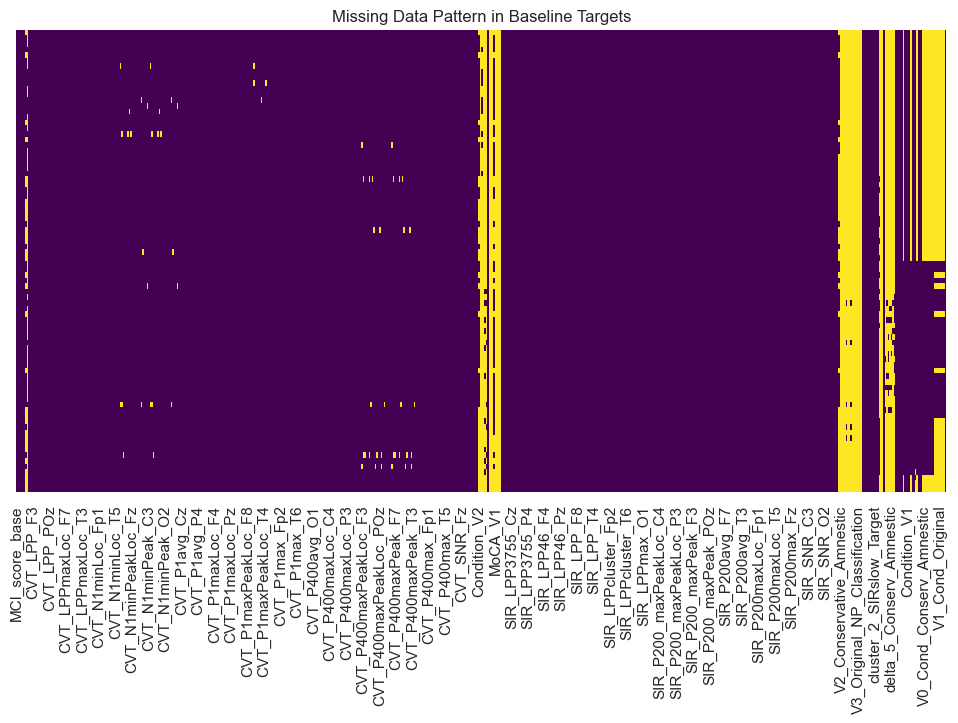

In [230]:
# Use Heatmap on Baseline targets to see the pattern of dropouts
baseline_target_cols = BASELINE_SPESIFIC_FEATURES + COMMON_FEATURES
plt.figure(figsize=(12, 6))
sns.heatmap(df_baseline[baseline_target_cols].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Data Pattern in Baseline Targets")
plt.show()

### 1.2.2 Longitudinal Visualization of Missingness Pattern

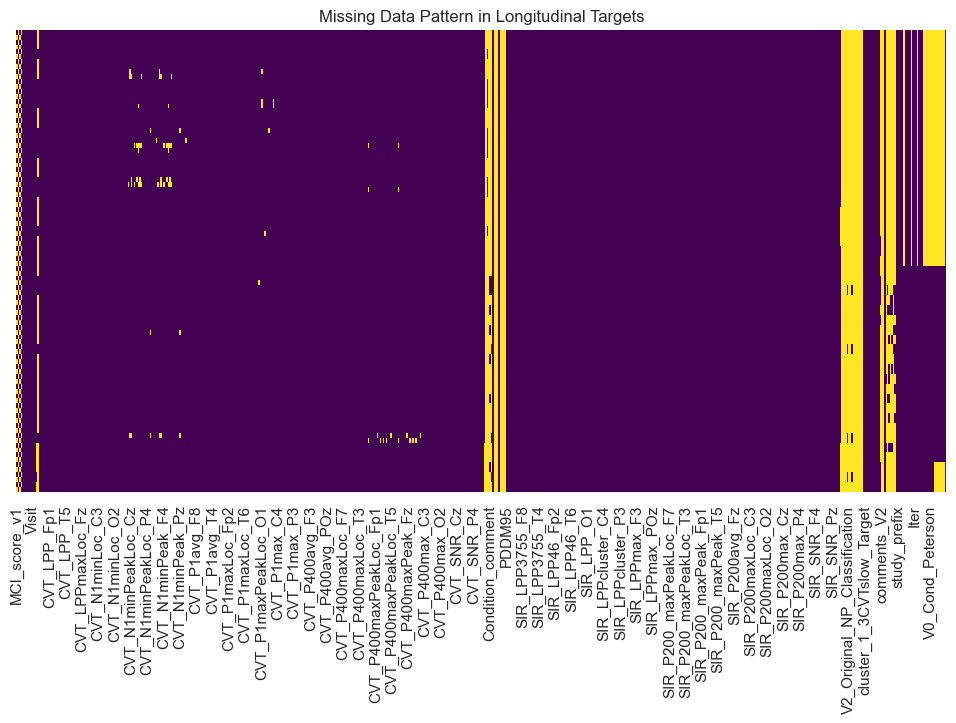

In [231]:
# Use Heatmap on Longitudinal targets to see the pattern of dropouts
longit_target_cols = LONGITUDINAL_SPESIFIC_FEATURES + COMMON_FEATURES
plt.figure(figsize=(12, 6))
sns.heatmap(df_longitudinal[longit_target_cols].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Data Pattern in Longitudinal Targets")
plt.show()

## 1.3 Discussion 1: Data Quality

--Will be filled

# 2. Target Variable Distribution Analysis (Clinical EDA)

## 2.1. Instantaneous Diagnosis (Baseline) Distribution

### 2.1.1 Baseline & Longitudinal Diagnosis Distribution (V1&v2)

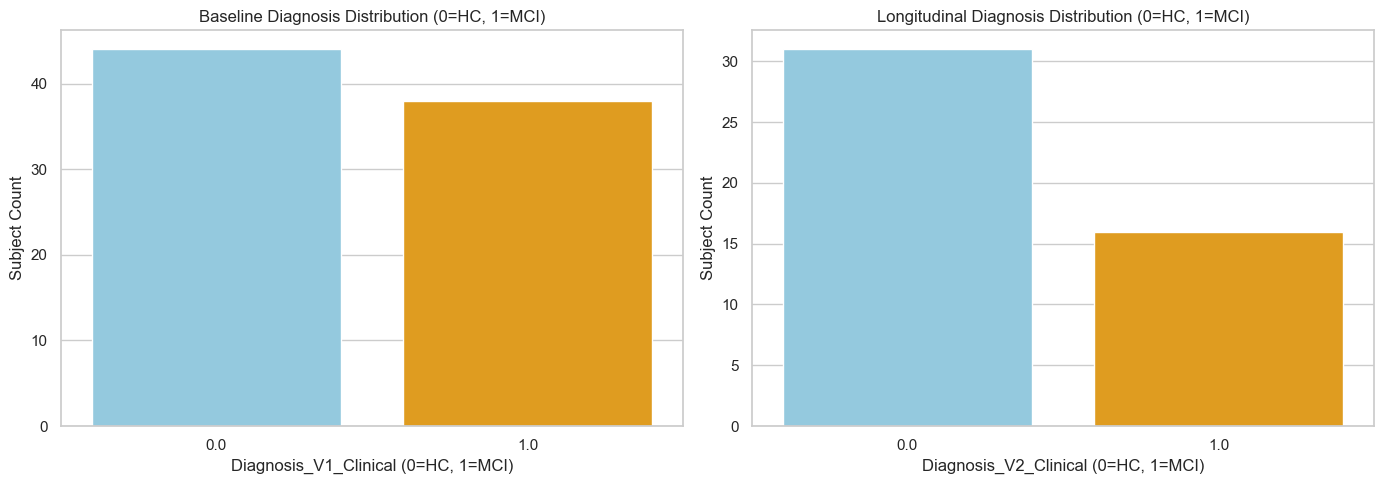

Imbalance Ratio (HC/MCI) - Baseline: 1.16
Imbalance Ratio (HC/MCI) - Longitudinal: 1.94


In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {0.0: 'skyblue', 1.0: 'orange'}

# Baseline Diagnosis
ax1 = sns.countplot(x=DIAGNOSIS_B, data=df_baseline, ax=axes[0], palette=colors, hue=DIAGNOSIS_B, legend=False)
axes[0].set_title("Baseline Diagnosis Distribution (0=HC, 1=MCI)")
axes[0].set_xlabel("Diagnosis_V1_Clinical (0=HC, 1=MCI)")
axes[0].set_ylabel("Subject Count")

# Longitudinal Diagnosis
ax2 = sns.countplot(x=DIAGNOSIS_V2_L, data=df_longitudinal, ax=axes[1], palette=colors, hue=DIAGNOSIS_V2_L, legend=False)
axes[1].set_title("Longitudinal Diagnosis Distribution (0=HC, 1=MCI)")
axes[1].set_xlabel("Diagnosis_V2_Clinical (0=HC, 1=MCI)")
axes[1].set_ylabel("Subject Count")

plt.tight_layout()
plt.show()

# Imbalance ratios
imbalance_ratio_baseline = df_baseline[DIAGNOSIS_B].value_counts().get(0, 1) / df_baseline[DIAGNOSIS_B].value_counts().get(1, 1)
imbalance_ratio_longitudinal = df_longitudinal[DIAGNOSIS_V2_L].value_counts().get(0, 1) / df_longitudinal[DIAGNOSIS_V2_L].value_counts().get(1, 1)
print(f"Imbalance Ratio (HC/MCI) - Baseline: {imbalance_ratio_baseline:.2f}")
print(f"Imbalance Ratio (HC/MCI) - Longitudinal: {imbalance_ratio_longitudinal:.2f}")


## 2.2. Progression Status Distributions Based on Δ-based & Threshold based Progression Calculation

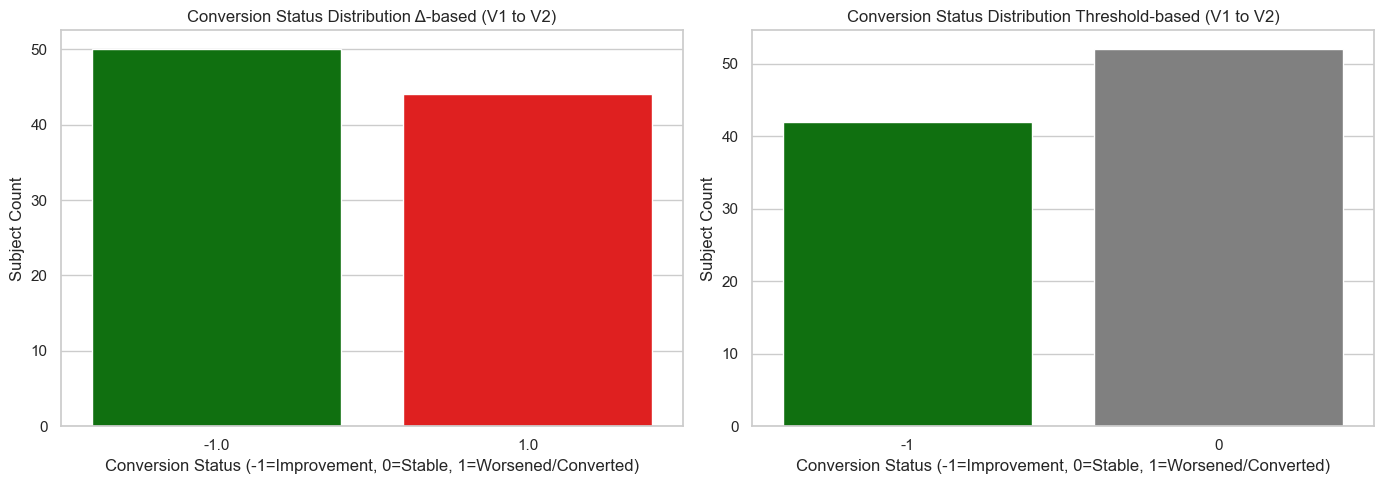

Progression Status Counts Δ-based:
MCI_progression
-1.0    50
 1.0    44
Name: count, dtype: int64
Progression Status Counts Threshold-based:
MCI_progression_diag_thrsld_based
 0    52
-1    42
Name: count, dtype: int64


In [233]:
# Check Class Imbalance for Prognosis Classification based on Δ-based & Threshold Progression Calculation

df_prog_delta = df_longitudinal.dropna(subset=[MCI_PROGRESSION_L])
df_prog_threshold = df_longitudinal.dropna(subset=[MCI_PROGRESSION_DIAG_THRSLD_BASED_L])
colors = { -1: 'green', 0: 'grey', 1: 'red' }

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Δ-based Progression Calculation
ax1 = sns.countplot(x=MCI_PROGRESSION_L, data=df_prog_delta, hue=MCI_PROGRESSION_L, 
                   palette=colors, legend=False, ax=axes[0])
axes[0].set_title("Conversion Status Distribution Δ-based (V1 to V2)")
axes[0].set_xlabel("Conversion Status (-1=Improvement, 0=Stable, 1=Worsened/Converted)")
axes[0].set_ylabel("Subject Count")

# Threshold Progression Calculation
ax2 = sns.countplot(x=MCI_PROGRESSION_DIAG_THRSLD_BASED_L, data=df_prog_threshold, hue=MCI_PROGRESSION_DIAG_THRSLD_BASED_L, 
                   palette=colors, legend=False, ax=axes[1])
axes[1].set_title("Conversion Status Distribution Threshold-based (V1 to V2)")
axes[1].set_xlabel("Conversion Status (-1=Improvement, 0=Stable, 1=Worsened/Converted)")
axes[1].set_ylabel("Subject Count")
plt.tight_layout()
plt.show()



print(f"Progression Status Counts Δ-based:\n{df_longitudinal[MCI_PROGRESSION_L].value_counts(dropna=False)}")
print(f"Progression Status Counts Threshold-based:\n{df_longitudinal[MCI_PROGRESSION_DIAG_THRSLD_BASED_L].value_counts(dropna=False)}")


## 2.3 Discussion: Target Distributions

--Will be filled

# 3. Univariate Separability Analysis (Baseline Features vs. Diagnosis)